In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from collections import Counter
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

In [ ]:
# Cargar CSV en un DataFrame
train = pd.read_csv("train/train_set.csv")
test = pd.read_csv("test/test_set.csv")

In [12]:
train

,ID,Sex,Age,Height,Weight,Team,Games,City,Sport,Medal_num
0,102549,F,20.0,168.000000,60.000000,United Kingdom,1984 Summer,Los Angeles,Swimming,0
1,128767,M,18.0,187.000000,100.000000,Germany,1988 Summer,Seoul,Swimming,0
2,6257,M,22.0,165.000000,63.000000,France,1996 Summer,Atlanta,Gymnastics,0
3,54746,F,23.0,179.000000,70.000000,China,2012 Summer,London,Swimming,0
4,13616,F,16.0,190.000000,78.000000,Cuba,1980 Summer,Moskva,Basketball,0
...,...,...,...,...,...,...,...,...,...,...
142679,28903,M,22.0,177.000000,90.000000,Russia,2008 Summer,Beijing,Cycling,0
142680,70632,M,18.0,182.000000,78.000000,Hungary,2014 Winter,Sochi,Short Track Speed Skating,0
142681,134946,M,38.0,189.000000,100.000000,Netherlands,2004 Summer,Athina,Sailing,0
142682,124270,F,26.0,179.533333,68.866667,Netherlands,1996 Summer,Atlanta,Beach Volleyball,0


In [13]:
X_train = train.drop(columns="Medal_num")
y_train = train.Medal_num
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

In [ ]:
#Con los datos obtenidos en los analisis anteriores, sabemos que para nuestro dataset mal balanceado, 
# # la tecnica que mejor funciona es un SMOTE + undersampling. 
# Además, necesitamos hacer un TargetEncoder a las columnas categoricas como preprocesado.
# Encoder para columnas categóricas 
encoder = TargetEncoder() 
X_cat_encoded = encoder.fit_transform(X_train[cat_cols], y_train) 
X_num = X_train[num_cols]  
X_train_encoded = pd.concat([X_cat_encoded, X_num], axis=1)


# Balanceo de clases
counter = Counter(y_train)
n_major = counter[0]

smote = SMOTE(random_state=42, sampling_strategy={
    1: int(n_major*0.5),
    2: int(n_major*0.5),
    3: int(n_major*0.5)
})

undersample = RandomUnderSampler(sampling_strategy={0: int(n_major*0.8)}, random_state=42)

X_res, y_res = smote.fit_resample(X_train_encoded, y_train)
X_res, y_res = undersample.fit_resample(X_res, y_res)

In [39]:
#Con los datos obtenidos en los analisis anteriores, sabemos que para nuestro dataset mal balanceado, 
# la tecnica que mejor funciona es un SMOTE + undersampling. Además, necesitamos hacer un TargetEncoder a las columnas categoricas como preprocesado.

#<<<<Pipeline>>>>
pipe_linear = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("smote", smote),
    ('undersample',undersample),
    ("classifier", LogisticRegression())
])

#<<<<Logistic classifier>>>>
logistic_params = {
    "scaler": [StandardScaler(), MinMaxScaler()],
    "pca__n_components": [3, 5,7],
    "classifier": [
        LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
    ],
    "classifier__C": [1, 10],
    "classifier__penalty": ["l2"]
}

pipe_trees = ImbPipeline(steps=[
    ("pca", PCA()),
    ("smote", smote),
    ('undersample',undersample),
    ("classifier", RandomForestClassifier())
])


#<<<<Random Forest>>>>
random_forest_params = {
    "pca__n_components": [3, 5,7],
    "classifier": [
        RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)
    ],
    "classifier__max_depth": [5, 10, None],
    "classifier__n_estimators": [100,200],
    "classifier__max_features": ["sqrt","log2"]
}

#<<<<<<XG Boost>>>>>>>
xgb_params = {
    "pca__n_components": [3, 5,7],
    "classifier": [
        XGBClassifier(
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
            eval_metric="logloss"
        )
    ],
    "classifier__n_estimators": [100,200],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.1,0.2]
}

#<<<<< Gradient Boosting Classifier>>>>>
gbct_params = {
    "pca__n_components": [3, 5,7],
    "classifier": [GradientBoostingClassifier(random_state=42)],
    "classifier__n_estimators": [100,200],
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.1,0.2]
}

#<<<<<Single Tree>>>>>

tree_params = {
    "pca__n_components": [3, 5,7],
    "classifier": [DecisionTreeClassifier(random_state=42)],
    "classifier__max_depth": [None, 3, 5, 10],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5]
}


pipe_ada = ImbPipeline(steps=[
    ("pca", PCA()),
    ("smote", smote),
    ('undersample',undersample),
    ("classifier", AdaBoostClassifier())
])

#<<<<<ADA Boost>>>>>
ada_params = {
    "pca__n_components": [3, 5,7],
    "classifier": [AdaBoostClassifier(random_state=42)],
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.1, 1]
}

In [38]:
#hacemos un bucle for para sacar una tabla con los mejores parametros de cada modelo y compararlos entre si

pipelines = [
    (pipe_linear, logistic_params),
    (pipe_trees, random_forest_params),
    (pipe_trees, xgb_params),
    (pipe_trees, gbct_params),
    (pipe_trees, tree_params),
    (pipe_ada, ada_params)
]

results = []

for pipe, params in pipelines:
    model_name = type(params["classifier"][0]).__name__

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=params,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    clf.fit(X_train_encoded, y_train)

    results.append({
        "model": model_name,
        "best_score": clf.best_score_,
        "best_params": clf.best_params_
    })

df = pd.DataFrame(results)
display(df)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\Alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,model,best_score,best_params
0,LogisticRegression,0.679558,{'classifier': LogisticRegression(class_weight...
1,RandomForestClassifier,0.781272,{'classifier': RandomForestClassifier(class_we...
2,XGBClassifier,0.758375,"{'classifier': XGBClassifier(base_score=None, ..."
3,GradientBoostingClassifier,0.755361,{'classifier': GradientBoostingClassifier(rand...
4,DecisionTreeClassifier,0.863503,{'classifier': DecisionTreeClassifier(random_s...
5,AdaBoostClassifier,0.863538,{'classifier': AdaBoostClassifier(random_state...


In [7]:
#Ahora que tenemos que el mejor modelo es el RandomForestClassifier, vamos a intentar optimizarlo aún mas utilizando una primera vez RandomizedSearchCV

#<<<<Pipeline>>>>
pipeRF = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

#<<<<Random Forest>>>>
random_forest_params = {
    'classifier__max_depth': [3,4, 5, None], 
    'classifier__n_estimators': [100,200,300],
    'classifier__max_features':['sqrt','log2']
}

clf_random = RandomizedSearchCV(
    estimator=pipeRF,
    param_distributions=random_forest_params,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [12]:
clf_random.fit(X_res, y_res)

c:\Users\Alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,Pipeline(step... n_jobs=-1))])
,param_distributions,"{'classifier__max_depth': [3, 4, ...], 'classifier__max_features': ['sqrt', 'log2'], 'classifier__n_estimators': [100, 200, ...]}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [13]:
print(clf_random.best_estimator_)
print(clf_random.best_score_)
print(clf_random.best_params_)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2', n_estimators=300,
                                        n_jobs=-1))])
0.7849170225466546
{'classifier__n_estimators': 300, 'classifier__max_features': 'log2', 'classifier__max_depth': None}


In [ ]:
#Vemos que no hemos afinado mucho, volvemos a intentarlo con otros parámetros

#Hagamos una última optimización para ver si podemos llegar a 0.8. Esta vez con GridSearchCV

#<<<<Pipeline>>>>
pipeRF = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

#<<<<Random Forest>>>>
random_forest_params_final = {
    'classifier__n_estimators': [300,350,400],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [None],
    'classifier__max_features': ['log2'],
    'classifier__min_samples_split': [2,5],
    'classifier__min_samples_leaf': [2,1]   
}

clf_CV_final = GridSearchCV(estimator = pipeRF,
                    param_grid = random_forest_params_final,
                    cv = 5,
                    verbose=2,
                    n_jobs=-1)

In [19]:
clf_CV_final.fit(X_res, y_res)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,estimator,Pipeline(step... n_jobs=-1))])
,param_grid,"{'classifier__criterion': ['gini'], 'classifier__max_depth': [None], 'classifier__max_features': ['log2'], 'classifier__min_samples_leaf': [2, 1], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,350


In [20]:
print(clf_CV_final.best_estimator_)
print(clf_CV_final.best_score_)
print(clf_CV_final.best_params_)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='log2', n_estimators=350,
                                        n_jobs=-1))])
0.7856263031038263
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 350}


In [32]:
#Entrenamos con el modelo final incluyendo dentro del pipe el preproces para poder aplicar al test
# Encoder para columnas categóricas

# Pipeline FINAL sin CV
final_model_pipe = ImbPipeline(steps=[
    ('encoder', TargetEncoder()),
    ('smote', SMOTE(
        random_state=42,
        sampling_strategy={
            1: int(n_major * 0.5),
            2: int(n_major * 0.5),
            3: int(n_major * 0.5)
        }
    )),
    ('undersample', RandomUnderSampler(
        sampling_strategy={0: int(n_major * 0.8)},
        random_state=42
    )),

    ('classifier', RandomForestClassifier(
        n_estimators=350,
        criterion='gini',
        max_depth=None,
        max_features='log2',
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

In [33]:
# ENTRENAR MODELO FINAL
final_model_pipe.fit(X_train, y_train)

,steps,"[('encoder', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['Sex', 'Team', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [34]:
# PREDICCIONES en train
y_pred_train = final_model_pipe.predict(X_train)
y_proba_train = final_model_pipe.predict_proba(X_train)

In [35]:
# Métricas de evaluación train 
accuracy = round(accuracy_score(y_train, y_pred_train),2)
f1 = round(f1_score(y_train, y_pred_train, average='weighted'),2)
precision = round(precision_score(y_train, y_pred_train, average='weighted'),2)
recall = round(recall_score(y_train, y_pred_train, average='weighted'),2)
conf_matrix = confusion_matrix(y_train, y_pred_train)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_train, y_pred_train))
print("\nMatriz de probabilidad:\n",y_proba_train)

Accuracy: 0.96
F1 Score: 0.96
Precision: 0.96
Recall: 0.96
Matriz de Confusión:
 [[120322    968    995    928]
 [   661   5734    123    147]
 [   537    114   5510    208]
 [   380    111    158   5788]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    123213
           1       0.83      0.86      0.84      6665
           2       0.81      0.87      0.84      6369
           3       0.82      0.90      0.86      6437

    accuracy                           0.96    142684
   macro avg       0.86      0.90      0.88    142684
weighted avg       0.96      0.96      0.96    142684


Matriz de probabilidad:
 [[0.96982912 0.01874231 0.00857143 0.00285714]
 [0.98554334 0.00874237 0.00285714 0.00285714]
 [1.         0.         0.         0.        ]
 ...
 [0.86423963 0.03290323 0.07142857 0.03142857]
 [0.88       0.05857143 0.03857143 0.02285714]
 [0.82395604 0.06580952 0.06857143 0.04166301]]


In [36]:
X_test = test.drop(columns="Medal_num")
y_test = test.Medal_num

In [37]:
# PREDICCIONES
y_pred = final_model_pipe.predict(X_test)
y_proba_test = final_model_pipe.predict_proba(X_test)

In [38]:
# Métricas de evaluación test 
accuracy = round(accuracy_score(y_test, y_pred),2)
f1 = round(f1_score(y_test, y_pred, average='weighted'),2)
precision = round(precision_score(y_test, y_pred, average='weighted'),2)
recall = round(recall_score(y_test, y_pred, average='weighted'),2)
conf_matrix = confusion_matrix(y_test, y_pred)
r2 = round(r2_score(y_test, y_pred),2)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
print("\nMatriz de probabilidad:\n",y_proba_test)

Accuracy: 0.87
F1 Score: 0.85
Precision: 0.85
Recall: 0.87
Matriz de Confusión:
 [[29456   455   467   425]
 [ 1045   418    86   118]
 [  947    85   425   135]
 [  765    92   134   618]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     30803
           1       0.40      0.25      0.31      1667
           2       0.38      0.27      0.31      1592
           3       0.48      0.38      0.43      1609

    accuracy                           0.87     35671
   macro avg       0.54      0.46      0.50     35671
weighted avg       0.85      0.87      0.85     35671


Matriz de probabilidad:
 [[0.76270422 0.11382325 0.05742857 0.06604396]
 [0.99714286 0.00285714 0.         0.        ]
 [0.98031745 0.00571429 0.01396826 0.        ]
 ...
 [0.98857143 0.00857143 0.         0.00285714]
 [0.97753053 0.01961232 0.00285714 0.        ]
 [0.95846704 0.01437789 0.02588523 0.00126984]]


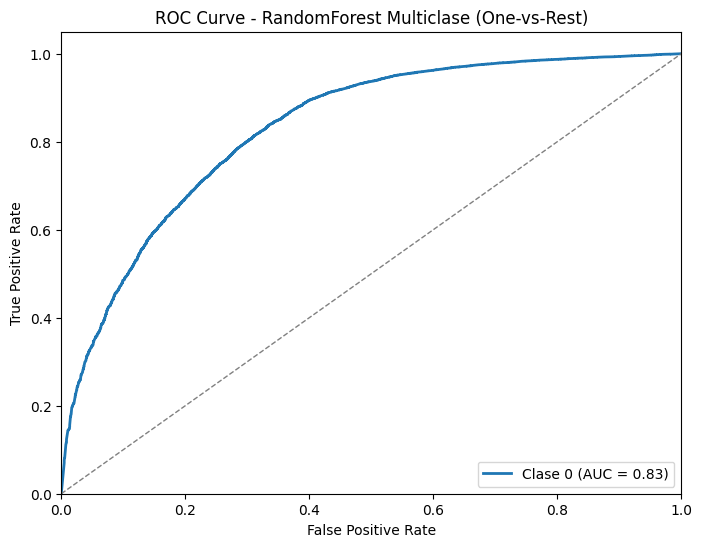

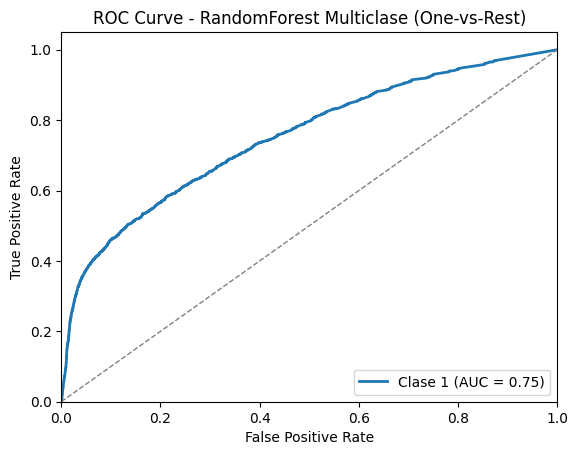

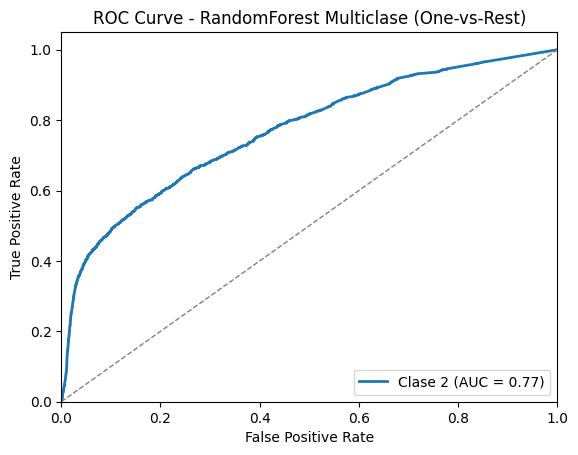

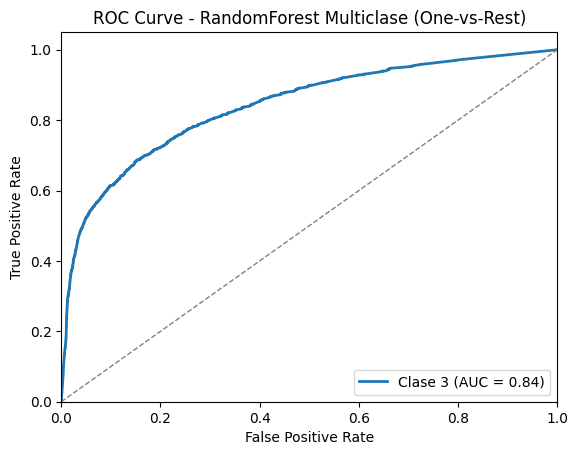

In [47]:
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes) # convierte a binario para cada clase
y_proba_roc = final_model_pipe.predict_proba(X_test) # shape (n_samples, n_classes)

plt.figure(figsize=(8,6))

for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_roc[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {c} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomForest Multiclase (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
pickle.dump(final_model_pipe, open('final_model_ML_multiclase.pkl', 'wb'))

In [40]:
modelo_importado = pickle.load(open("final_model_ML_multiclase.pkl", 'rb'))
modelo_importado

,steps,"[('encoder', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['Sex', 'Team', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [41]:
modelo_importado.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(35671,))